In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#dataset_path = '/content/drive/MyDrive/Colab Notebooks/fuzzy_dataset'

In [ ]:
#pip install split-folders

In [ ]:
# import splitfolders

# splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/fuzzy_dataset", # The location of dataset
#                   output="/content/drive/MyDrive/Colab Notebooks/fuzzy_split_data", # The output location
#                   ratio=(.8, .1, .1), # The ratio of splited dataset
#                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                   move=False, # If you choose to move, turn this into True
#                   seed=42
#                   )

In [ ]:
import os 
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2
from keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/stacked_split_data/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/stacked_split_data/test'
val_path = '/content/drive/MyDrive/Colab Notebooks/stacked_split_data/val'

In [ ]:
labels = os.listdir(train_path)
print(labels)
for label in labels:
  print(label)
  print(labels.index(label))

['Viral Pneumonia', 'Lung_Opacity', 'COVID', 'Normal']
Viral Pneumonia
0
Lung_Opacity
1
COVID
2
Normal
3


In [ ]:
train_n_path = train_path+'/Normal/'
train_c_path = train_path+'/COVID/'
train_l_path = train_path+'/Lung_Opacity'
train_v_path = train_path+'/Viral Pneumonia/'

test_n_path = test_path+'/Normal/'
test_c_path = test_path+'/COVID/'
test_l_path = test_path+'/Lung_Opacity'
test_v_path = test_path+'/Viral Pneumonia/'

val_n_path = val_path+'/Normal/'
val_c_path = val_path+'/COVID/'
val_l_path = val_path+'/Lung_Opacity'
val_v_path = val_path+'/Viral Pneumonia/'

In [ ]:
print(f'Number of normal images is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of covid images is {len(os.listdir(train_c_path))}') #length of COVID training images 
print(f'Number of lung_opacity images is {len(os.listdir(train_l_path))}') #length of lung_opacity training images 
print(f'Number of pneumonia images is {len(os.listdir(train_v_path))}') #length of pneumonia training images 
print(f'Total training images is  {len(os.listdir(train_n_path)) + len(os.listdir(train_c_path)) + len(os.listdir(train_l_path)) + len(os.listdir(train_v_path))}')

Number of normal images is 8153
Number of covid images is 2892
Number of lung_opacity images is 4809
Number of pneumonia images is 1076
Total training images is  16930


In [ ]:
print(f'Number of normal images is {len(os.listdir(test_n_path))}') #length of normal test images
print(f'Number of covid images is {len(os.listdir(test_c_path))}') #length of COVID test images 
print(f'Number of lung_opacity images is {len(os.listdir(test_l_path))}') #length of lung_opacity test images 
print(f'Number of pneumonia images is {len(os.listdir(test_v_path))}') #length of pneumonia test images 
print(f'Total testing images is  {len(os.listdir(test_n_path)) + len(os.listdir(test_c_path)) + len(os.listdir(test_l_path)) + len(os.listdir(test_v_path))}')

Number of normal images is 1020
Number of covid images is 363
Number of lung_opacity images is 602
Number of pneumonia images is 135
Total testing images is  2120


In [ ]:
print(f'Number of normal images is {len(os.listdir(val_n_path))}') #length of normal val images
print(f'Number of covid images is {len(os.listdir(val_c_path))}') #length of COVID val images 
print(f'Number of lung_opacity images is {len(os.listdir(val_l_path))}') #length of lung_opacity val images 
print(f'Number of pneumonia images is {len(os.listdir(val_v_path))}') #length of pneumonia val images 
print(f'Total testing images is  {len(os.listdir(val_n_path)) + len(os.listdir(val_c_path)) + len(os.listdir(val_l_path)) + len(os.listdir(val_v_path))}')

Number of normal images is 1019
Number of covid images is 361
Number of lung_opacity images is 601
Number of pneumonia images is 134
Total testing images is  2115


In [ ]:
img_size = 224

In [ ]:
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data(train_path)
test = get_training_data(test_path)
val = get_training_data(val_path)

<ipython-input-11-226148560195>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = 0.2,  
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    horizontal_flip = True, 
)

In [ ]:
train_datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(
              optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
train_n_path = train_path+'/Normal/'
train_c_path = train_path+'/COVID/'
train_l_path = train_path+'/Lung_Opacity'
train_v_path = train_path+'/Viral Pneumonia/'

total = len(os.listdir(train_n_path)) + len(os.listdir(train_c_path)) + len(os.listdir(train_l_path)) + len(os.listdir(train_v_path))

covid = len(os.listdir(train_c_path))
normal = len(os.listdir(train_n_path))
viral = len(os.listdir(train_v_path))
lung_opacity = len(os.listdir(train_l_path))


weight_for_c = 1/covid * (total/4.0)
weight_for_n = 1/normal * (total/4.0)
weight_for_v = 1/viral * (total/4.0)
weight_for_l = 1/lung_opacity * (total/4.0)

class_weight = {0:weight_for_v, 1:weight_for_l, 2:weight_for_c, 3:weight_for_n}
class_weight

{0: 3.9335501858736057,
 1: 0.880120607194843,
 2: 1.4635200553250347,
 3: 0.5191340610818104}

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [ ]:
import keras.utils as ku


y_train = ku.to_categorical(y_train, 4)
y_test = ku.to_categorical(y_test, 4)
y_val = ku.to_categorical(y_val, 4)

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/stacked_baseline.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]
history = model.fit(train_datagen.flow(x_train, y_train, batch_size = 32), 
                    epochs = 25, validation_data = train_datagen.flow(x_val, y_val), 
                    callbacks = callbacks, class_weight = class_weight)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 1.1128 - accuracy: 0.5080
Epoch 1: val_loss improved from inf to 1.26304, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_baseline.h5
530/530 [==============================] - 192s 333ms/step - loss: 1.1128 - accuracy: 0.5080 - val_loss: 1.2630 - val_accuracy: 0.5527 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.6050
Epoch 2: val_loss did not improve from 1.26304
530/530 [==============================] - 179s 338ms/step - loss: 0.8497 - accuracy: 0.6050 - val_loss: 1.6256 - val_accuracy: 0.3721 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.7650 - accuracy: 0.6448
Epoch 3: val_loss did not improve from 1.26304

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
530/530 [==============================] - 179s 337ms/step - loss: 0.7650 - accuracy: 0.6448 - val_loss: 1.3651 - val_accu

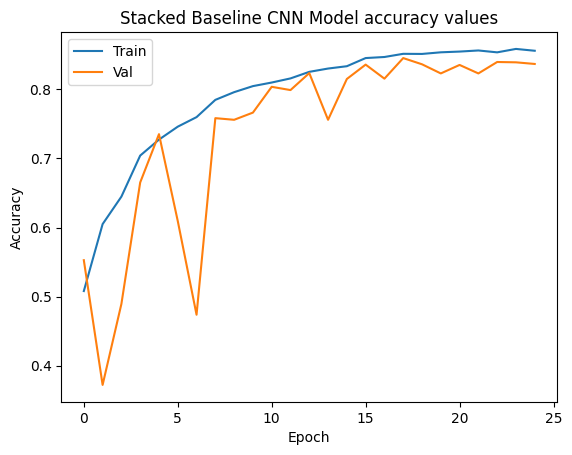

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Stacked Baseline CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

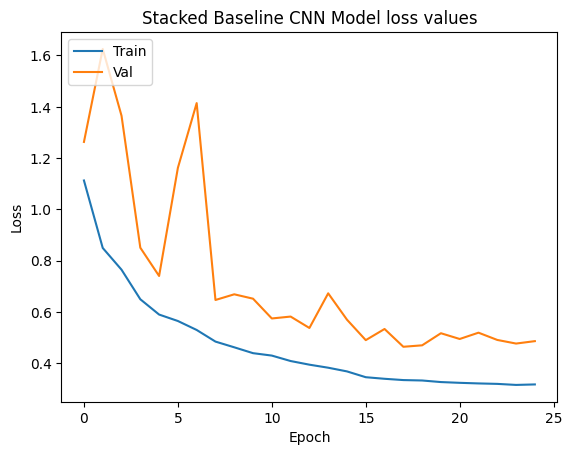

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked Baseline CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 1s 10ms/step


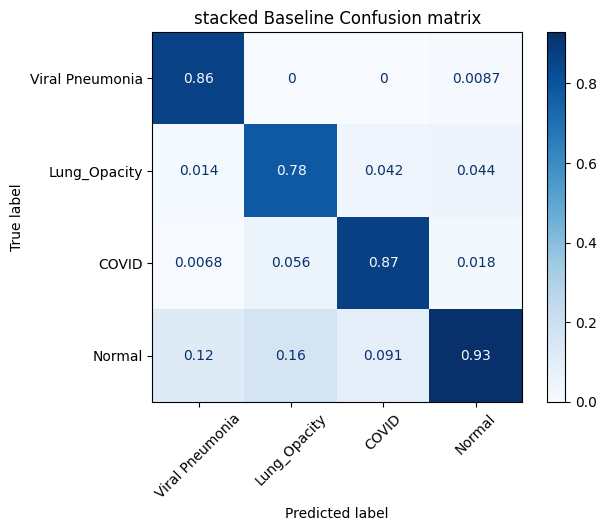

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/stacked_baseline.h5')
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_baseline.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('stacked Baseline Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

Viral Pneumonia       0.86      0.94      0.90       135
   Lung_Opacity       0.78      0.90      0.84       602
          COVID       0.87      0.84      0.85       363
         Normal       0.93      0.84      0.88      1020

       accuracy                           0.87      2120
      macro avg       0.86      0.88      0.87      2120
   weighted avg       0.87      0.87      0.87      2120



VGG16 Fuzzy




In [ ]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_1.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history=vgg_model.fit(
  train_datagen.flow(x_train, y_train, batch_size = 32), epochs = 25, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight, callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.6856
Epoch 1: val_loss improved from inf to 0.77362, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_1.h5
530/530 [==============================] - 187s 350ms/step - loss: 0.7215 - accuracy: 0.6856 - val_loss: 0.7736 - val_accuracy: 0.6941 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.7516
Epoch 2: val_loss did not improve from 0.77362
530/530 [==============================] - 187s 352ms/step - loss: 0.5652 - accuracy: 0.7516 - val_loss: 1.1233 - val_accuracy: 0.6236 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.5306 - accuracy: 0.7660
Epoch 3: val_loss improved from 0.77362 to 0.67955, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_1.h5
530/530 [==============================] - 187s 354ms/step - loss: 0.5306 - accuracy: 0.7660 - val_loss: 0.6795 -

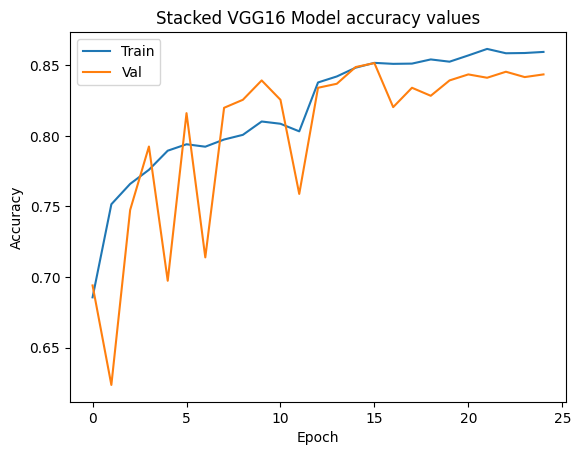

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Stacked VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

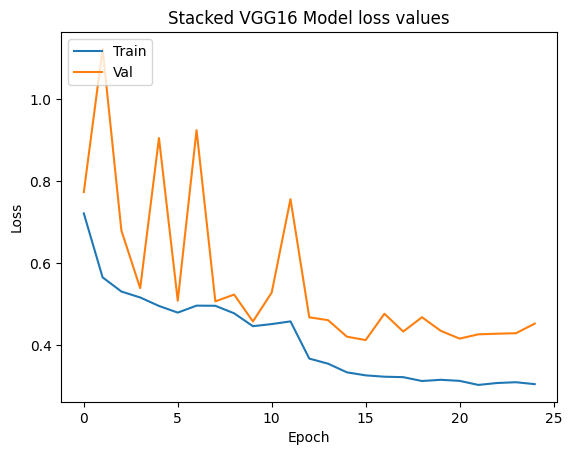

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Stacked VGG16 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 2s 28ms/step


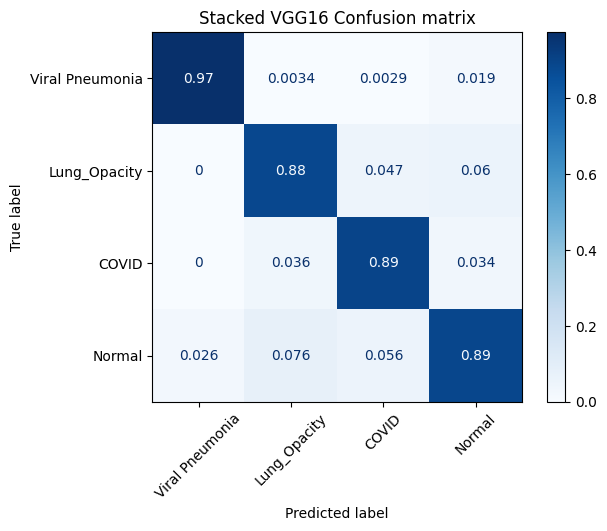

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_1.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked VGG16 Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

Viral Pneumonia       0.97      0.83      0.90       135
   Lung_Opacity       0.88      0.87      0.88       602
          COVID       0.89      0.84      0.87       363
         Normal       0.89      0.93      0.91      1020

       accuracy                           0.89      2120
      macro avg       0.91      0.87      0.89      2120
   weighted avg       0.89      0.89      0.89      2120



VGG16 Fuzzy Fine Tuning

In [ ]:
IMAGE_SIZE = [224, 224]
vgg_trainable = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg_trainable.trainable = True

# Retrain the last 3 layers (all lower layers will be kept frozen)
for layer in vgg_trainable.layers[:-3]:
    layer.trainable = False

x_trainable = Flatten()(vgg_trainable.output)
prediction = Dense(4, activation='softmax')(x_trainable)
model_trainable = Model(inputs=vgg_trainable.input, outputs=prediction)
model_trainable.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_trainable.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history=model_trainable.fit(
  train_datagen.flow(x_train, y_train, batch_size = 32), epochs = 25, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight, callbacks = callbacks,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.8069 - accuracy: 0.6265
Epoch 1: val_loss improved from inf to 0.75234, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_2.h5
530/530 [==============================] - 189s 353ms/step - loss: 0.8069 - accuracy: 0.6265 - val_loss: 0.7523 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.7449
Epoch 2: val_loss improved from 0.75234 to 0.55438, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_2.h5
530/530 [==============================] - 188s 354ms/step - loss: 0.5624 - accuracy: 0.7449 - val_loss: 0.5544 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.7830
Epoch 3: val_loss improved from 0.55438 to 0.50883, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_2.h5
530/530 [=====================

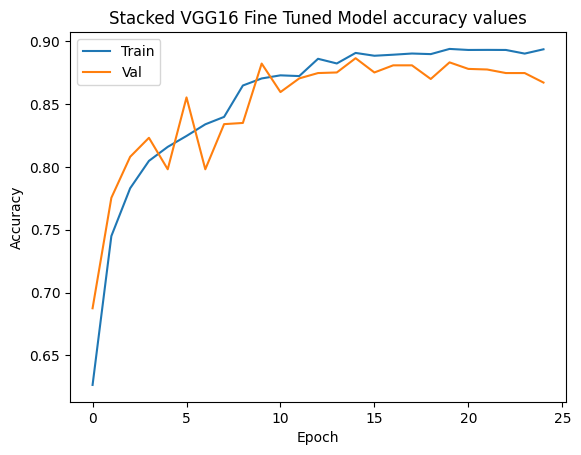

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Stacked VGG16 Fine Tuned Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

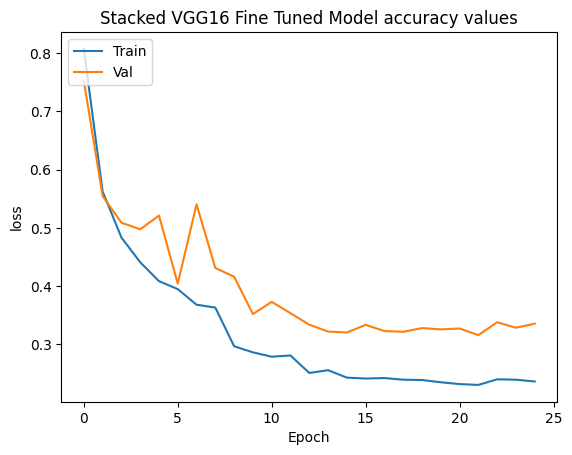

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Stacked VGG16 Fine Tuned Model accuracy values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 2s 21ms/step


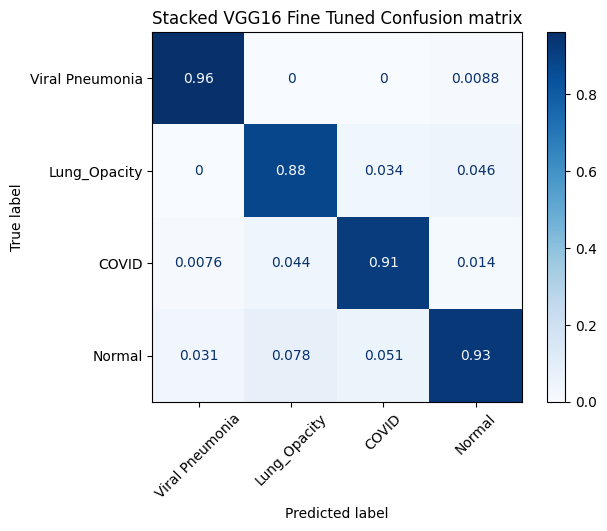

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_vgg_model_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked VGG16 Fine Tuned Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 2s 23ms/step - loss: 0.2400 - accuracy: 0.9151
Test loss: 0.24003446102142334
Test accuracy: 0.9150943160057068


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

Viral Pneumonia       0.96      0.93      0.95       135
   Lung_Opacity       0.88      0.90      0.89       602
          COVID       0.91      0.88      0.90       363
         Normal       0.93      0.93      0.93      1020

       accuracy                           0.92      2120
      macro avg       0.92      0.91      0.92      2120
   weighted avg       0.92      0.92      0.92      2120



Resnet101 Fuzzy Model

In [ ]:
base_model = ResNet101V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)
num_classes = 4
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=prediction)
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_1.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history_resnet=resnet_model.fit(
  train_datagen.flow(x_train, y_train),
  validation_data=train_datagen.flow(x_val, y_val),
  epochs=25,
  callbacks = callbacks,
  class_weight = class_weight,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 3.7132 - accuracy: 0.7051
Epoch 1: val_loss improved from inf to 3.80987, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_1.h5
530/530 [==============================] - 195s 338ms/step - loss: 3.7132 - accuracy: 0.7051 - val_loss: 3.8099 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 3.8409 - accuracy: 0.7552
Epoch 2: val_loss did not improve from 3.80987
530/530 [==============================] - 179s 337ms/step - loss: 3.8409 - accuracy: 0.7552 - val_loss: 4.6285 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 3.8325 - accuracy: 0.7719
Epoch 3: val_loss did not improve from 3.80987
530/530 [==============================] - 180s 340ms/step - loss: 3.8325 - accuracy: 0.7719 - val_loss: 4.2719 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 4/25
530/530 [=========================

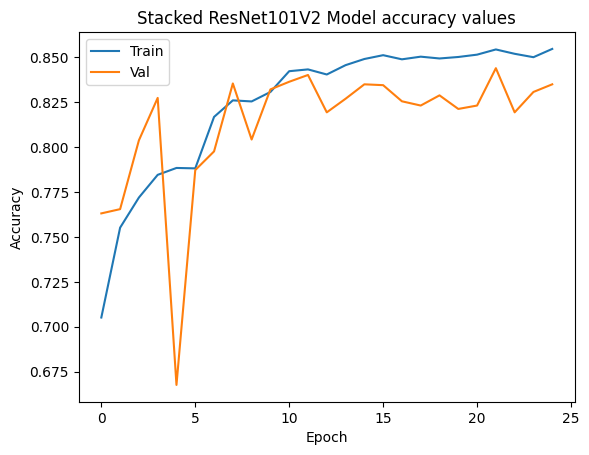

In [ ]:
plt.plot(model_history_resnet.history['accuracy'])
plt.plot(model_history_resnet.history['val_accuracy'])
plt.title('Stacked ResNet101V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

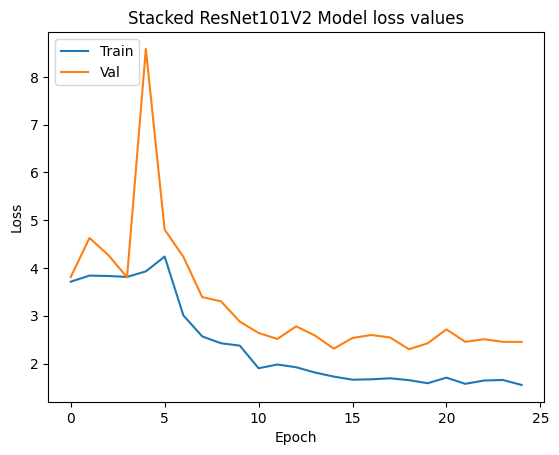

In [ ]:
plt.plot(model_history_resnet.history['loss'])
plt.plot(model_history_resnet.history['val_loss'])
plt.title('Stacked ResNet101V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 3s 23ms/step


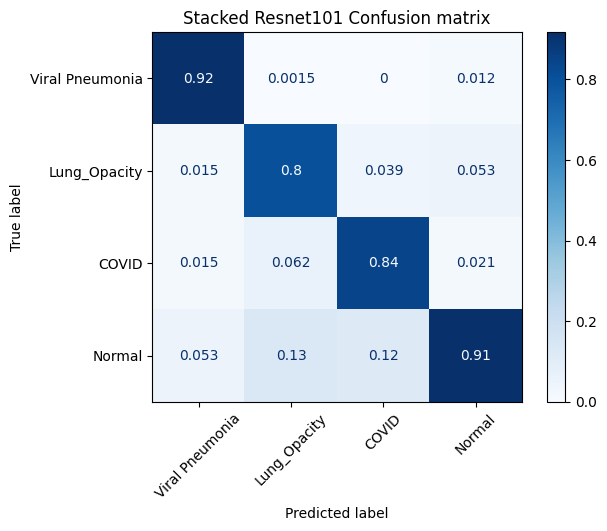

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_1.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)

result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked Resnet101 Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_1.h5')
score = test_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 4s 26ms/step - loss: 1.9163 - accuracy: 0.8679
Test loss: 1.916332483291626
Test accuracy: 0.8679245114326477


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

Viral Pneumonia       0.92      0.90      0.91       135
   Lung_Opacity       0.80      0.89      0.84       602
          COVID       0.84      0.83      0.83       363
         Normal       0.91      0.87      0.89      1020

       accuracy                           0.87      2120
      macro avg       0.87      0.87      0.87      2120
   weighted avg       0.87      0.87      0.87      2120



Resnet101 Fuzzy Model Finetuning

In [ ]:
res_trainable = ResNet101V2(input_shape = [224, 224, 3] ,weights='imagenet', include_top=False)
num_classes = 4
res_trainable.trainable = True
for layer in res_trainable.layers[:-10]:
    layer.trainable = False
x = Flatten()(res_trainable.output)
prediction = Dense(num_classes, activation='softmax')(x)
fine_resnet_model = Model(inputs=res_trainable.input, outputs=prediction)
fine_resnet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
fine_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_2.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, learning_rate_reduction]

start = datetime.now()

model_history_fine_resnet=fine_resnet_model.fit(
  train_datagen.flow(x_train, y_train),
  validation_data=train_datagen.flow(x_val, y_val),
  epochs=25,
  callbacks = callbacks,
  class_weight = class_weight,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.6991
Epoch 1: val_loss improved from inf to 0.82003, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_2.h5
530/530 [==============================] - 190s 340ms/step - loss: 0.9516 - accuracy: 0.6991 - val_loss: 0.8200 - val_accuracy: 0.7518 - lr: 0.0010
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.7783
Epoch 2: val_loss improved from 0.82003 to 0.56714, saving model to /content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_2.h5
530/530 [==============================] - 183s 346ms/step - loss: 0.5051 - accuracy: 0.7783 - val_loss: 0.5671 - val_accuracy: 0.7924 - lr: 0.0010
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.7978
Epoch 3: val_loss did not improve from 0.56714
530/530 [==============================] - 182s 343ms/step - loss: 0.4497 - accuracy: 0.7978 - val_loss: 0.

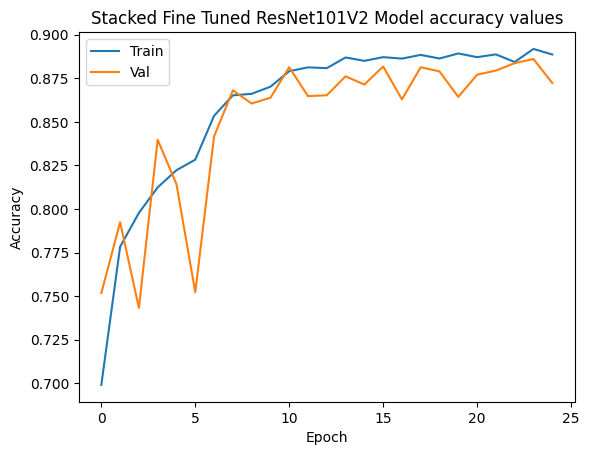

In [ ]:
plt.plot(model_history_fine_resnet.history['accuracy'])
plt.plot(model_history_fine_resnet.history['val_accuracy'])
plt.title('Stacked Fine Tuned ResNet101V2 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

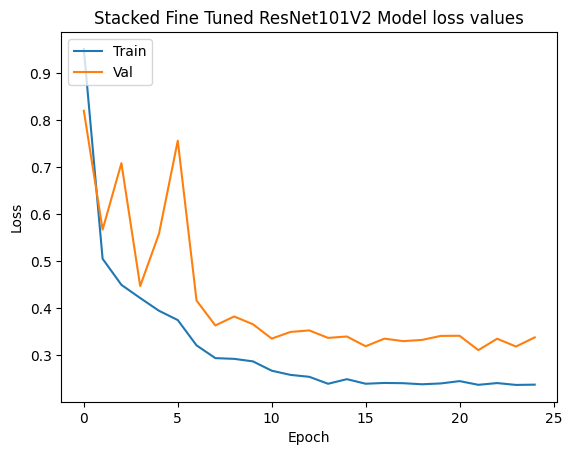

In [ ]:
plt.plot(model_history_fine_resnet.history['loss'])
plt.plot(model_history_fine_resnet.history['val_loss'])
plt.title('Stacked Fine Tuned ResNet101V2 Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

67/67 [==============================] - 3s 23ms/step


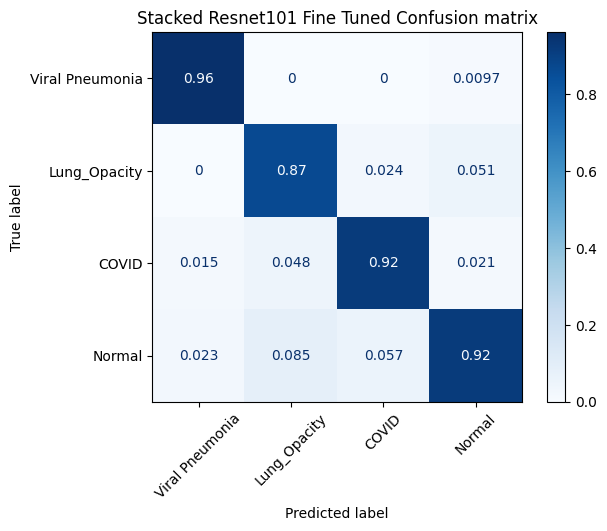

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_2.h5')
y_prediction = test_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
labels = os.listdir(train_path)
y_test_conf=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test_conf, y_prediction , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacked Resnet101 Fine Tuned Confusion matrix')
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/stacked_resnet_model_2.h5')
score = test_model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 4s 26ms/step - loss: 0.2604 - accuracy: 0.9057
Test loss: 0.2604200541973114
Test accuracy: 0.9056603908538818


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_conf, y_prediction, target_names=labels))

                 precision    recall  f1-score   support

Viral Pneumonia       0.96      0.93      0.94       135
   Lung_Opacity       0.87      0.90      0.88       602
          COVID       0.92      0.85      0.88       363
         Normal       0.92      0.93      0.92      1020

       accuracy                           0.91      2120
      macro avg       0.92      0.90      0.91      2120
   weighted avg       0.91      0.91      0.91      2120



In [ ]:
model_history_fine_resnet.history

{'loss': [0.9515653252601624,
  0.5051437616348267,
  0.4496588706970215,
  0.421617716550827,
  0.3945210576057434,
  0.3747256100177765,
  0.32085609436035156,
  0.2937556207180023,
  0.29219484329223633,
  0.2868598401546478,
  0.2670137286186218,
  0.25811049342155457,
  0.25398218631744385,
  0.2392193228006363,
  0.24897074699401855,
  0.2392653375864029,
  0.2409505844116211,
  0.24040988087654114,
  0.2381281852722168,
  0.23989859223365784,
  0.24486947059631348,
  0.2369711995124817,
  0.24069784581661224,
  0.2367478907108307,
  0.23732632398605347],
 'accuracy': [0.6990549564361572,
  0.7783225178718567,
  0.7977554798126221,
  0.8124040365219116,
  0.8222681879997253,
  0.828292965888977,
  0.8534554243087769,
  0.865209698677063,
  0.8660956621170044,
  0.870171308517456,
  0.8790313005447388,
  0.8812758326530457,
  0.8808032870292664,
  0.8869462609291077,
  0.8849970698356628,
  0.8871234655380249,
  0.8862965106964111,
  0.8884229063987732,
  0.8863555788993835,
  0.8